In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis

df = pd.read_excel('data/app_data.xlsx')

cond1 = df['Diagnosis'].notna()

df = df[cond1].reset_index(drop=True)

# Pediatric Appendicitis

In [299]:
df['Diagnosis'].fillna('').value_counts()

Diagnosis
appendicitis       463
no appendicitis    317
Name: count, dtype: int64

In [300]:
df['Severity'].fillna('').value_counts()

Severity
uncomplicated    661
complicated      119
Name: count, dtype: int64

In [301]:
df['Management'].fillna('').value_counts()

Management
conservative                 483
primary surgical             270
secondary surgical            26
simultaneous appendectomy      1
Name: count, dtype: int64

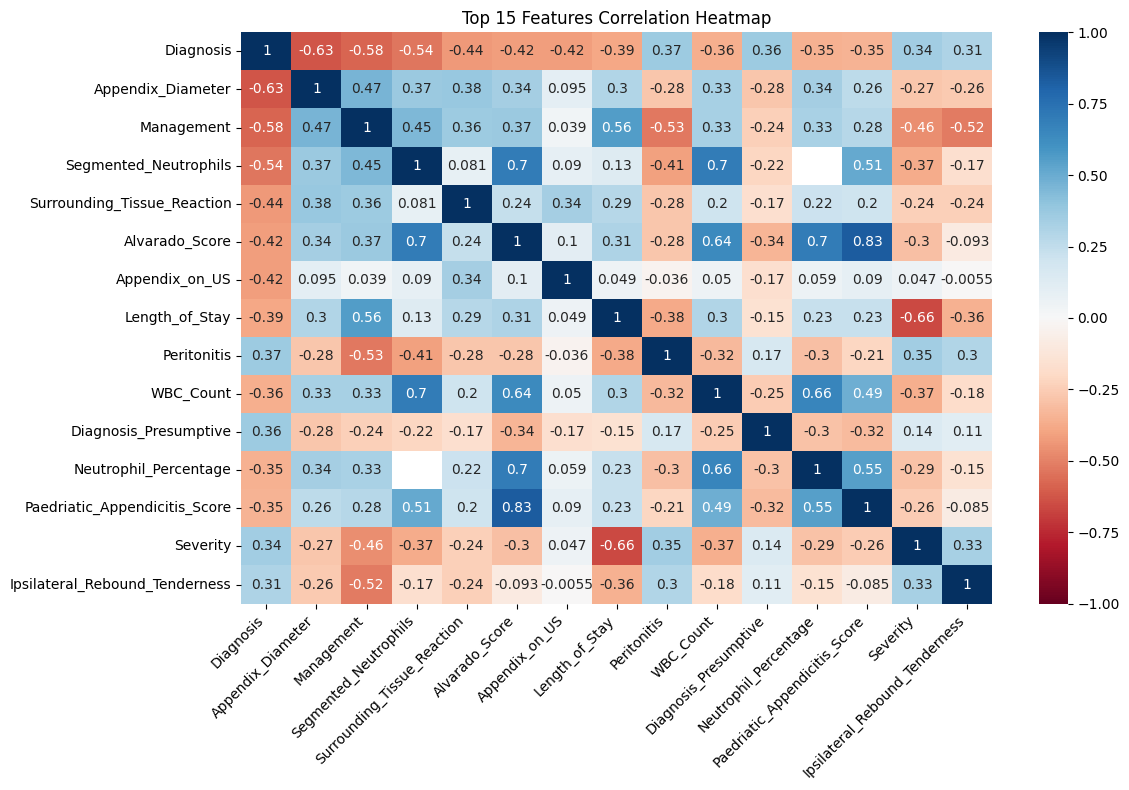

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Calculate correlations with target variable
correlations = df.corr()['Diagnosis'].sort_values(ascending=False)

# Create a figure for the correlation heatmap
plt.figure(figsize=(12, 8))
top_features = correlations.abs().nlargest(15)  # Get top 15 correlated features
top_corr = df[top_features.index].corr()

# Create heatmap
sns.heatmap(top_corr, 
            annot=True, 
            cmap='RdBu', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Top 15 Features Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


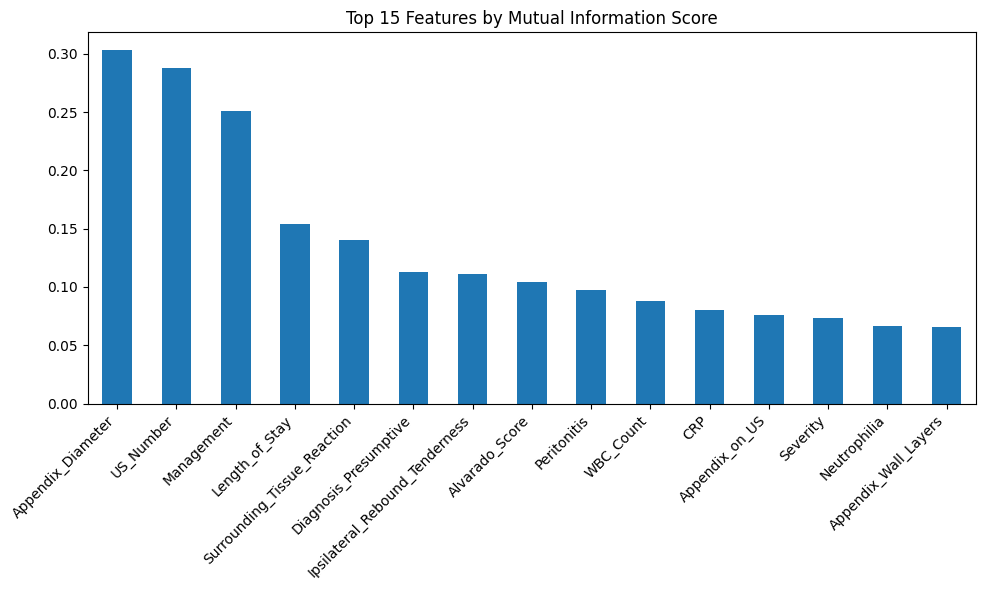


Summary Statistics for Top 10 Most Correlated Features:
       Appendix_Diameter  Management  Segmented_Neutrophils  \
count         498.000000  780.000000              54.000000   
mean            7.762651    0.416667              64.929630   
std             2.536671    0.563757              15.085025   
min             2.700000    0.000000              32.000000   
25%             6.000000    0.000000              54.500000   
50%             7.500000    0.000000              64.500000   
75%             9.100000    1.000000              77.500000   
max            17.000000    3.000000              91.000000   

       Surrounding_Tissue_Reaction  Alvarado_Score  Appendix_on_US  \
count                   780.000000      730.000000      780.000000   
mean                      0.589744        5.921918        1.642308   
std                       0.881064        2.155972        0.487592   
min                       0.000000        0.000000        0.000000   
25%                      

In [310]:
from sklearn.feature_selection import mutual_info_classif

df['Diagnosis'] = df['Diagnosis'].fillna(0)
# Calculate mutual information scores
mi_scores = mutual_info_classif(df.drop('Diagnosis', axis=1).fillna(0), df['Diagnosis'].fillna(0))
mi_series = pd.Series(mi_scores, index=df.drop('Diagnosis', axis=1).columns)
mi_series = mi_series.sort_values(ascending=False)

# Plot mutual information scores
plt.figure(figsize=(10, 6))
mi_series.head(15).plot(kind='bar')
plt.title('Top 15 Features by Mutual Information Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Top 10 Most Correlated Features:")
top_10_features = correlations.abs().nlargest(11).index[1:]  # Exclude target variable
print(df[top_10_features].describe())

# Calculate class distribution
print("\nClass Distribution:")
print(df['Diagnosis'].value_counts(normalize=True) * 100)

In [311]:

df = pd.read_excel('data/app_data.xlsx')

cond1 = df['Diagnosis'].notna()

df = df[cond1].reset_index(drop=True)

In [312]:
# transform target variable

df['has_appendicitis'] = (df['Diagnosis']=="appendicitis").astype('int')

#df['has_appendicitis'] = (df['Severity']=="complicated").astype('int')

# drop other target variables, we can't use them to predict
df.drop(columns=['Severity', 'Diagnosis', 'Management'], inplace=True)


# 'Diagnosis_Presumptive'
df.drop(columns=['Diagnosis_Presumptive', 'Length_of_Stay'], inplace=True)

In [313]:
def get_summary(var, data):
    pct_nan = round(df[var].isna().sum()/len(df)*100, 2)
    return f"{var}: {len(data.unique())} unique values: {df[var].unique()}.  {pct_nan}% null values"


binary_vars = ['Surrounding_Tissue_Reaction',  'Pathological_Lymph_Nodes', 'Dysuria', 'Bowel_Wall_Thickening', 
               'Conglomerate_of_Bowel_Loops',  'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
               'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite',
               # described as categorical, however, they are binary (yes/no) variables
               'Neutrophilia', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 
               'Free_Fluids', 'Target_Sign', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis']

for var in binary_vars:
    print(get_summary(var, df[var]))


import numpy as np

for var in binary_vars:
    if df[var].dtype == 'O':
        df[var] = np.select([df[var]=='yes', df[var]=='no'], [1, 0], default=np.nan)

Surrounding_Tissue_Reaction: 3 unique values: ['yes' nan 'no'].  67.69% null values
Pathological_Lymph_Nodes: 3 unique values: ['yes' nan 'no'].  73.97% null values
Dysuria: 3 unique values: ['no' 'yes' nan].  3.46% null values
Bowel_Wall_Thickening: 3 unique values: [nan 'no' 'yes'].  87.31% null values
Conglomerate_of_Bowel_Loops: 3 unique values: [nan 'no' 'yes'].  94.49% null values
Appendix_on_US: 3 unique values: ['yes' 'no' nan].  0.38% null values
Migratory_Pain: 3 unique values: ['no' 'yes' nan].  0.9% null values
Lower_Right_Abd_Pain: 3 unique values: ['yes' 'no' nan].  0.77% null values
Contralateral_Rebound_Tenderness: 3 unique values: ['yes' 'no' nan].  1.67% null values
Coughing_Pain: 3 unique values: ['no' 'yes' nan].  1.79% null values
Nausea: 3 unique values: ['no' 'yes' nan].  0.77% null values
Loss_of_Appetite: 3 unique values: ['yes' 'no' nan].  1.03% null values
Neutrophilia: 3 unique values: ['no' 'yes' nan].  6.15% null values
Psoas_Sign: 3 unique values: ['yes' 

In [314]:
df['Sex'] = np.select([df['Sex']=='male', df['Sex']=='female', df['Sex']==np.nan], [1, 0, np.nan], default=np.nan)

In [315]:

# transform categorical variables
#df['Sex'] = df['Sex'].astype('category')

categorical_columns = df.select_dtypes(include=['object']).columns


for var in categorical_columns:
    print(get_summary(var, df[var]))



Ketones_in_Urine: 5 unique values: ['++' 'no' nan '+++' '+'].  25.38% null values
RBC_in_Urine: 5 unique values: ['+' 'no' nan '++' '+++'].  26.15% null values
WBC_in_Urine: 5 unique values: ['no' '+' nan '+++' '++'].  25.26% null values
Stool: 5 unique values: ['normal' 'constipation' 'diarrhea' nan 'constipation, diarrhea'].  1.92% null values
Peritonitis: 4 unique values: ['no' 'local' 'generalized' nan].  0.9% null values
Appendix_Wall_Layers: 5 unique values: ['intact' nan 'raised' 'upset' 'partially raised'].  72.05% null values
Appendicolith: 4 unique values: ['suspected' nan 'yes' 'no'].  91.15% null values
Perfusion: 5 unique values: [nan 'hyperperfused' 'hypoperfused' 'no' 'present'].  91.92% null values
Perforation: 5 unique values: ['no' nan 'suspected' 'yes' 'not excluded'].  89.62% null values
Appendicular_Abscess: 4 unique values: ['no' nan 'suspected' 'yes'].  89.1% null values
Abscess_Location: 8 unique values: [nan 'Douglas' 'retrovesikal' 'rechter Unterbauch' 'perity

In [316]:
import unicodedata
import re

def clean_text(text):
    """
    Clean and normalize text to handle special characters and symbols
    """
    if pd.isna(text):
        return text
    
    text = str(text) #.lower()
    
    # Standardize plus symbols
    text = text.replace('+++', 'plus_3')
    text = text.replace('++', 'plus_2')
    text = text.replace('+', 'plus_1')
    
    # Standarize no
    if text.lower().strip() in ['no', 'keine',]:
        return 'no'
    
    # Remove special characters
    text = ''.join(char for char in unicodedata.normalize('NFKD', text)
                  if unicodedata.category(char)[0] != 'P' or char in 'äöüß')
      
    # Replace special characters with underscore
    text = re.sub(r'[^a-z0-9]+', '_', text)
    
    # Remove multiple underscores
    text = re.sub(r'_+', '_', text)
    text = text.strip('_')
    
    return text


for column in categorical_columns:
    # First clean the values in the original column
    df[column] = df[column].apply(clean_text)
    
    dummy_df = pd.get_dummies(df[column], prefix=column)

    for col in dummy_df.columns:
        dummy_df[col] = dummy_df[col].fillna(False).astype(bool)
    
    # Concatenate and drop original column
    df = pd.concat([df, dummy_df], axis=1).drop(column, axis=1)


#import pandas as pd

#for col in object_cols:
#  df[col] = df[col].fillna(False).astype(bool)

In [317]:
df.describe()

,Age,BMI,Sex,Height,Weight,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,...,Target_Sign,Surrounding_Tissue_Reaction,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,has_appendicitis
count,780.000000,754.000000,779.000000,755.000000,778.000000,730.000000,730.000000,777.000000,498.000000,773.000000,...,138.000000,252.000000,203.000000,99.000000,43.000000,60.000000,71.000000,140.000000,66.000000,780.000000
mean,11.341863,18.905041,0.517330,147.997616,43.158625,5.921918,5.253425,0.648649,7.762651,0.272962,...,0.630435,0.825397,0.758621,0.555556,0.488372,0.383333,0.647887,0.921429,0.772727,0.593590
std,3.529881,4.387860,0.500021,19.737546,17.397830,2.155972,1.958456,0.477700,2.536671,0.445770,...,0.484445,0.380383,0.428978,0.499433,0.505781,0.490301,0.481028,0.270035,0.422282,0.491478
min,0.000000,7.827983,0.000000,53.000000,3.960000,0.000000,0.000000,0.000000,2.700000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.198426,15.721375,0.000000,137.000000,29.500000,4.000000,4.000000,0.000000,6.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,11.437372,18.044121,1.000000,149.500000,41.300000,6.000000,5.000000,1.000000,7.500000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,14.040383,21.185877,1.000000,163.000000,54.000000,8.000000,7.000000,1.000000,9.100000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,18.360000,38.156221,1.000000,192.000000,103.000000,10.000000,10.000000,1.000000,17.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [318]:
df.head()

,Age,BMI,Sex,Height,Weight,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,...,Gynecological_Findings_kleine_varzyste_rechts,Gynecological_Findings_n_beiden_varien_ysten_darstellbar_links_var_mit_regelrechter_erfusion_rechts_etwas_vergro_ert_keine_eindeutige_erfusion_nachweisbar_etrovesikal_freie_lu_ssigkeit_mit_innenecho,Gynecological_Findings_no,Gynecological_Findings_unauffa_llig,Gynecological_Findings_usschluss_gyn_rsache_der_eschwerden,Gynecological_Findings_usschluss_pathologischer_varialbefund,Gynecological_Findings_varialzyste,Gynecological_Findings_varialzyste_re,Gynecological_Findings_varialzysten,Gynecological_Findings_yste_terus
0,12.68,16.9,0.0,148.0,37.0,4.0,3.0,1.0,7.1,0.0,...,False,False,False,False,False,False,False,False,False,False
1,14.10,31.9,1.0,147.0,69.5,5.0,4.0,0.0,NaN,1.0,...,False,False,False,False,False,False,False,False,False,False
2,14.14,23.3,0.0,163.0,62.0,5.0,3.0,0.0,NaN,0.0,...,False,False,False,False,False,False,False,False,False,False
3,16.37,20.6,0.0,165.0,56.0,7.0,6.0,0.0,NaN,1.0,...,False,False,False,False,False,False,False,False,False,False
4,11.08,16.9,0.0,163.0,45.0,5.0,6.0,1.0,7.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [319]:
df['Ketones_in_Urine_no']

0      False
1       True
2       True
3       True
4       True
       ...  
775    False
776    False
777     True
778    False
779     True
Name: Ketones_in_Urine_no, Length: 780, dtype: bool

# Model

In [320]:

target_variable = "has_appendicitis"


FeaturesName = df.columns.drop(target_variable)

df_train = df.sample(frac=0.8, random_state=1)
df_test = df.drop(df_train.index)

X_train = df_train[FeaturesName]
X_test = df_test[FeaturesName]
Y_train = df_train[TargetName]
Y_test = df_test[TargetName]


In [321]:
X_train.shape, X_test.shape, 

((624, 118), (156, 118))

In [322]:
# pip install xgboost
import xgboost as xgb

xbg_1 = xgb.XGBClassifier(objective = "binary:logistic", 
                          seed=42)

xbg_1.fit(X_train, 
          Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Sum of TP + TN + FP + FN =  366 + 258 + 0 + 0  = 624
True


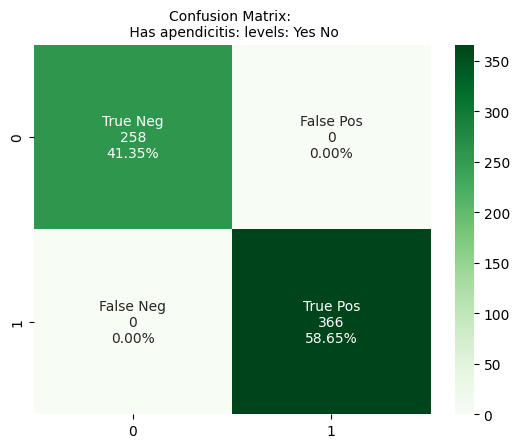

In [323]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = xbg_1.predict(X_train)

cm = confusion_matrix(Y_train, y_pred)

TN = cm[0][0] 
TP = cm[1][1] 
FP = cm[0][1] 
FN = cm[1][0] 

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{:,.0f}'.format(value) for value in
                cm.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')
plt.title('Confusion Matrix: \n Has apendicitis: levels: Yes No', fontsize = 10) 
plt.xlabel('', fontsize = 15) 
plt.ylabel('', fontsize = 15)

print("Sum of TP + TN + FP + FN = ", str(TP) + " + " + str(TN) + " + " +str(FP)+ " + "+ str(FN), " = " + str(TP+TN+FP+FN) + "\n" +str(len(Y_train) ==TP+TN+FP+FN))


In [324]:
from sklearn.metrics import confusion_matrix,accuracy_score

def print_accuracy(model_1, X_train_x, Y_train_x, which_set):
    y_pred = model_1.predict(X_train_x)
    acc=accuracy_score(Y_train_x,y_pred)*100
    print('Model accuracy for '+which_set + ' dataset is {} % '.format(round(acc,3)))


print_accuracy(model_1=xbg_1, X_train_x=X_train, Y_train_x=Y_train, which_set="train")

print_accuracy(model_1=xbg_1, X_train_x=X_test, Y_train_x=Y_test, which_set="test")


Model accuracy for train dataset is 100.0 % 
Model accuracy for test dataset is 98.077 % 
